# Análisis De Sentimientos Relacionados Al Suicidio 

Jose Manuel Montes Contreras

Instalacion de packages / librerias

In [1]:
!pip install neattext==0.1.2
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-gpu

Requirement already up-to-date: tensorflow in c:\users\moncont\anaconda3\lib\site-packages (2.7.0)
Requirement already up-to-date: tensorflow-gpu in c:\users\moncont\anaconda3\lib\site-packages (2.7.0)


### Importación de librerías

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np 
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import neattext.functions as nfx
import keras
from keras.preprocessing.text import Tokenizer
import seaborn as sns
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.layers import Embedding,Dense,LSTM,Bidirectional,GlobalMaxPooling1D,Input,Dropout
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
import pickle
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras import optimizers
from sklearn.metrics import classification_report

### Importacion del dataset y datos generales del mismo

In [3]:
posts = pd.read_csv('Suicide_Detection.csv')

In [4]:
posts.head(5)

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [5]:
posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB


In [6]:
posts.isna().sum().sort_values()

Unnamed: 0    0
text          0
class         0
dtype: int64

### Histograma de los datos

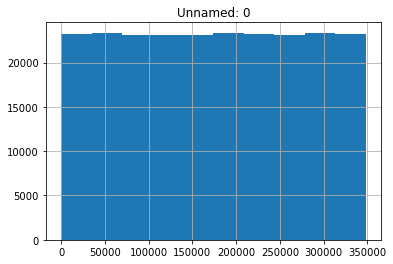

In [7]:
posts.hist()
plt.show()

### Numero total de No-Suicida vs Suicida

In [8]:
class_count = posts.groupby("class", as_index=False)['class'].count()
class_count

,class
0,116037
1,116037


### Diagrama de barras de las clases

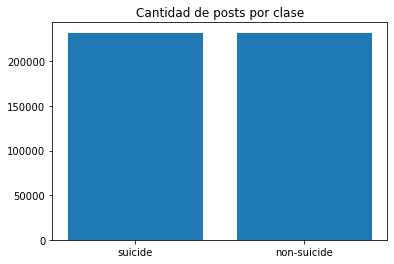

In [9]:
plt.bar(posts['class'], posts['class'].count())
plt.title('Cantidad de posts por clase')
plt.show()

### División de datos de entrenamiento y prueba

In [10]:
train_posts,test_posts=train_test_split(posts,test_size=0.3,random_state=45)

In [11]:
train_posts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162451 entries, 160596 to 137630
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  162451 non-null  int64 
 1   text        162451 non-null  object
 2   class       162451 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.0+ MB


In [12]:
test_posts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69623 entries, 150470 to 188753
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  69623 non-null  int64 
 1   text        69623 non-null  object
 2   class       69623 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.1+ MB


### Limpieza de datos

In [13]:
def clean_text(text):
    text_length=[]
    cleaned_text=[]
    for sent in tqdm(text):
        sent=sent.lower()
        sent=nfx.remove_special_characters(sent)
        sent=nfx.remove_stopwords(sent)
        text_length.append(len(sent.split()))
        cleaned_text.append(sent)
    return cleaned_text,text_length

In [14]:
#Almacenamos los datos limpios
texto_limpio_train,texto_train_length=clean_text(train_posts.text)
texto_limpio_test,texto_test_length=clean_text(test_posts.text)

100%|█████████████████████████████████████████████████████████████████████████| 69623/69623 [00:04<00:00, 15534.22it/s]


In [15]:
#Realizamos la tokenizacion de los datos limpios
tokenizer=Tokenizer()
tokenizer.fit_on_texts(texto_limpio_train)

### Frecuencia de las palabras

In [16]:
#Almacenamos la frecuencia de  las palabras
word_freq=pd.DataFrame(tokenizer.word_counts.items(),columns=['word','count']).sort_values(by='count',ascending=False)

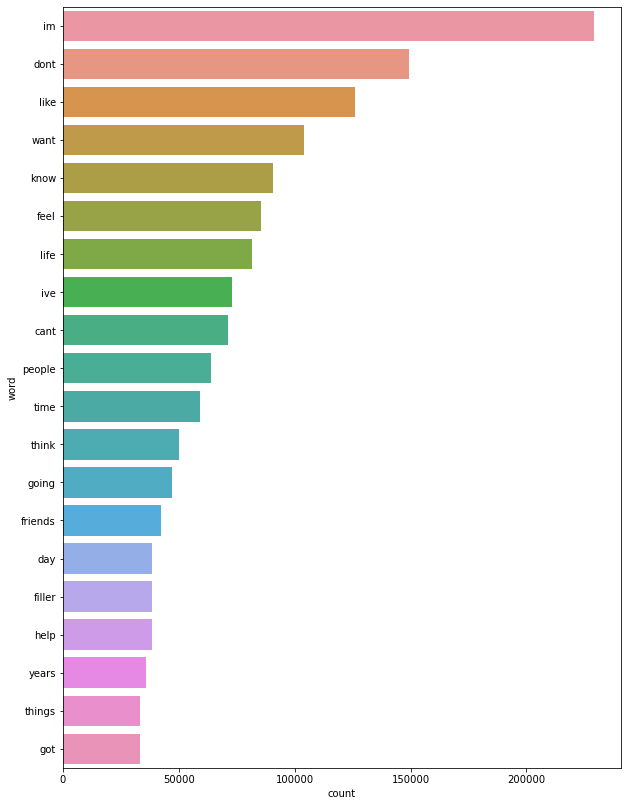

In [17]:
plt.figure(figsize=(10,14))
sns.barplot(x='count',y='word',data=word_freq.iloc[:20])
plt.show()

In [18]:
train_text_seq=tokenizer.texts_to_sequences(texto_limpio_train)
train_text_pad=pad_sequences(train_text_seq,maxlen=50)

In [19]:
test_text_seq=tokenizer.texts_to_sequences(texto_limpio_test)
test_text_pad=pad_sequences(test_text_seq,maxlen=50)

In [20]:
lbl_target=LabelEncoder()
train_output=lbl_target.fit_transform(train_posts['class'])
test_output=lbl_target.transform(test_posts['class'])

In [21]:
# Cargamos GloVe, que es un algoritmo de aprendizaje no supervisado para 
# obtener representaciones vectoriales de palabras.
with open('glove.840B.300d.pkl', 'rb') as fp:
    glove_embedding = pickle.load(fp)

In [22]:
v=len(tokenizer.word_index)

embedding_matrix=np.zeros((v+1,300), dtype=float)
for word,idx in tokenizer.word_index.items():
    embedding_vector=glove_embedding.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx]=embedding_vector

In [23]:
#Detenemos el entrenamiento cuando una métrica monitoreada haya dejado de mejorar.
early_stop=EarlyStopping(patience=5)
reducelr=ReduceLROnPlateau(patience=3)

In [24]:
#Instalamos Keras
!pip install keras

## Modelo Secuencial 1

In [25]:
#Aplicamos el Modelo Secuencial
#Agregamos las capas
model=Sequential()
model.add(Input(shape=(50,)))
model.add(Dropout(0.5))
model.add(Dense(200,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
opti = tf.keras.optimizers.SGD(learning_rate=0.1,momentum=0.09)
model.compile(optimizer=opti,loss='binary_crossentropy',metrics=['accuracy'])

In [26]:
#Entrenamos el Modelo
r1=model.fit(train_text_pad,train_output,validation_data=(test_text_pad,test_output),
            epochs=20,batch_size=100,callbacks=[early_stop,reducelr])

Epoch 1/20
1625/1625 [==============================] - 9s 4ms/step - loss: 106388267767045226204109996032.0000 - accuracy: 0.4984 - val_loss: 0.6931 - val_accuracy: 0.4997 - lr: 0.1000
Epoch 2/20
1625/1625 [==============================] - 5s 3ms/step - loss: 1163163074560.0000 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.4997 - lr: 0.1000
Epoch 3/20
1625/1625 [==============================] - 5s 3ms/step - loss: 19060103168.0000 - accuracy: 0.4981 - val_loss: 0.6932 - val_accuracy: 0.5003 - lr: 0.1000
Epoch 4/20
1625/1625 [==============================] - 5s 3ms/step - loss: 38462875523967409455104.0000 - accuracy: 0.4988 - val_loss: 0.6932 - val_accuracy: 0.4997 - lr: 0.1000
Epoch 5/20
1625/1625 [==============================] - 4s 2ms/step - loss: 1148204.8750 - accuracy: 0.4982 - val_loss: 0.6931 - val_accuracy: 0.4997 - lr: 0.0100
Epoch 6/20
1625/1625 [==============================] - 4s 2ms/step - loss: 580129554169856.0000 - accuracy: 0.4978 - val_loss: 0.6931 -

In [27]:
#Calculamos el resultado del modelo
result = model.evaluate(test_text_pad,
                        test_output)

2176/2176 [==============================] - 2s 993us/step - loss: 0.6931 - accuracy: 0.5003


In [28]:
#Imprimirmos las metricas
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.6931464076042175
accuracy 0.500337541103363


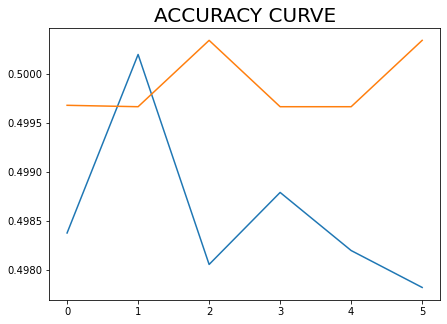

In [29]:
#Graficamos la Curva del Accuracy (Precisión)
plt.figure(figsize=(7,5))
plt.plot(r1.history['accuracy'])
plt.plot(r1.history['val_accuracy'])
plt.title('ACCURACY CURVE',fontdict={'size':20})
plt.show()

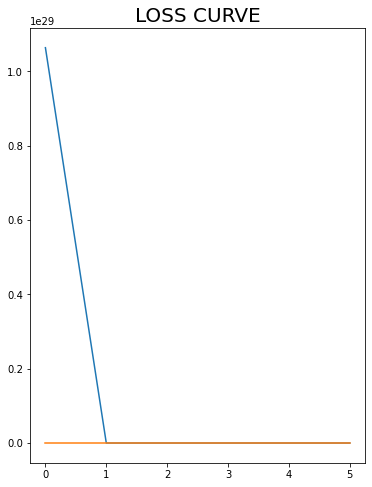

In [31]:
#Calculamos la curva de Perdida (Loss)
plt.figure(figsize=(6,8))
plt.plot(r1.history['loss'])
plt.plot(r1.history['val_loss'])
plt.title('LOSS CURVE',fontdict={'size':20})
plt.show()

## Modelo Secuencial 2

In [32]:
#Aplicamos el modelo secuencial, esta vez sin dropouts y con otras capas adicionales
model2 =Sequential()
model2.add(Input(shape=(50,)))
model2.add(Embedding(v+1,300,weights=[embedding_matrix],trainable=False))
model2.add(LSTM(20,return_sequences=True))
model2.add(GlobalMaxPooling1D())
model2.add(Dense(200,activation='relu'))
model2.add(Dense(1,activation='sigmoid'))
opti = tf.keras.optimizers.SGD(learning_rate=0.1,momentum=0.09)
model2.compile(optimizer=opti,loss='binary_crossentropy',metrics=['accuracy'])

In [33]:
r2=model2.fit(train_text_pad,train_output,validation_data=(test_text_pad,test_output),
            epochs=20,batch_size=256,callbacks=[early_stop,reducelr])

Epoch 1/20
635/635 [==============================] - 37s 51ms/step - loss: 0.3597 - accuracy: 0.8453 - val_loss: 0.2706 - val_accuracy: 0.8899 - lr: 0.1000
Epoch 2/20
635/635 [==============================] - 38s 60ms/step - loss: 0.2502 - accuracy: 0.9004 - val_loss: 0.2312 - val_accuracy: 0.9085 - lr: 0.1000
Epoch 3/20
635/635 [==============================] - 35s 55ms/step - loss: 0.2315 - accuracy: 0.9082 - val_loss: 0.2663 - val_accuracy: 0.8909 - lr: 0.1000
Epoch 4/20
635/635 [==============================] - 37s 58ms/step - loss: 0.2171 - accuracy: 0.9147 - val_loss: 0.2327 - val_accuracy: 0.9090 - lr: 0.1000
Epoch 5/20
635/635 [==============================] - 45s 70ms/step - loss: 0.2050 - accuracy: 0.9193 - val_loss: 0.2007 - val_accuracy: 0.9213 - lr: 0.1000
Epoch 6/20
635/635 [==============================] - 47s 75ms/step - loss: 0.1931 - accuracy: 0.9247 - val_loss: 0.2335 - val_accuracy: 0.9057 - lr: 0.1000
Epoch 7/20
635/635 [==============================] - 58s 

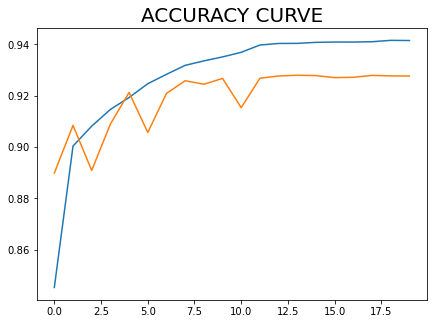

In [34]:
plt.figure(figsize=(7,5))
plt.plot(r2.history['accuracy'])
plt.plot(r2.history['val_accuracy'])
plt.title('ACCURACY CURVE',fontdict={'size':20})
plt.show()

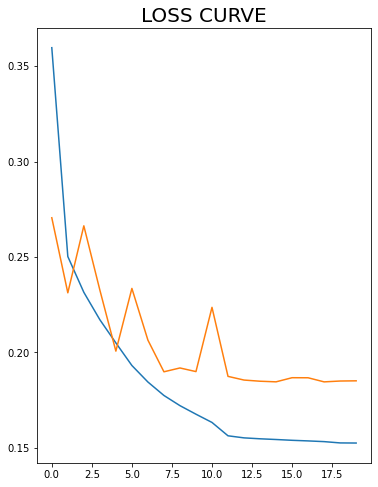

In [35]:
plt.figure(figsize=(6,8))
plt.plot(r2.history['loss'])
plt.plot(r2.history['val_loss'])
plt.title('LOSS CURVE',fontdict={'size':20})
plt.show()

In [36]:
result = model2.evaluate(test_text_pad,
                        test_output)
for name, value in zip(model2.metrics_names, result):
    print(name, value)

2176/2176 [==============================] - 20s 9ms/step - loss: 0.1851 - accuracy: 0.9277
loss 0.18510802090168
accuracy 0.9276962876319885
